In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [12,8]

from ipywidgets import interact, interact_manual
import ipywidgets as widgets
import folium
from folium import plugins

#Edmonton data API set up
#from sodapy import Socrata
#client = Socrata("data.edmonton.ca", None)

# Data preparation

### ETL

> The dataset used here was the original dataset with genre information imported using Google Books API. If you would like to see how it was done, please check the repository on [Github](https://github.com/FernandoMeiraFilho/Edmonton-Library-EDA)

Loading the data set and making some cleaning in some features

In [2]:
data = pd.read_csv('ImportingPubDate/finalPubDataset.csv').iloc[:,7:]

data = data[data.title.notnull()]
data = data[data.branch_name.notnull()]

#Taking off the name of the authors from the title
data['title'] = data['title'].apply(lambda x: x.split(' /')[0])

#Cleaning the branch names
pats_dict = {' Branch': '', ' Library': '', ' Lending Machine': '',
            'Promenad ' : 'Promenade '}
for k, v in pats_dict.items():
    data['branch_name_mod'] = data['branch_name'].apply(lambda x: x.replace(k,v))
    

data['title'] = data['title'].apply(lambda x: x.split(' /')[0])


# fixing some identified genre misclassifications
data.genre = data.genre.apply(lambda x: 'Fiction' if x=='Bildungsromans' else x) # Paper Town book misclassifications
data.genre = data.genre.apply(lambda x: 'Fiction' if x=='FICTION' else x) # ficition duplicate
data.genre = data.genre.apply(lambda x: 'Self-Help' if x=='PHILOSOPHY' else x) # 12 rules for life misclassification

#Tanking off timestamp from date column - personal preference though..
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.date


data.head()

,row_id,branch_id,branch_name,holds,title,author,date,url,genre,branch_name_mod,pubdate
0,EPLLON20150316The girl on the train / Paula Ha...,EPLLON,Londonderry Branch,36,The girl on the train,Hawkins Paula,2015-03-16,http://epl.bibliocommons.com/search?t=smart&q=...,Drama,Londonderry Branch,2018-05-12
1,EPLLON20150316The maze runner / James Dashner,EPLLON,Londonderry Branch,18,The maze runner,Dashner James,2015-03-16,http://epl.bibliocommons.com/search?t=smart&q=...,Young Adult Fiction,Londonderry Branch,2014-08-05
2,EPLLON20150316Crash & burn : a novel / Lisa Ga...,EPLLON,Londonderry Branch,17,Crash & burn : a novel,Gardner Lisa,2015-03-16,http://epl.bibliocommons.com/search?t=smart&q=...,Young Adult Fiction,Londonderry Branch,2013-02-19
3,EPLLON20150316Gray Mountain / John Grisham,EPLLON,Londonderry Branch,14,Gray Mountain,Grisham John,2015-03-16,http://epl.bibliocommons.com/search?t=smart&q=...,Fiction,Londonderry Branch,2015
4,EPLLON20150316Cambridge IELTS ... : examinatio...,EPLLON,Londonderry Branch,14,Cambridge IELTS ... : examination papers from ...,University of Cambridge Local Examinations Syn...,2015-03-16,http://epl.bibliocommons.com/search?t=smart&q=...,Foreign Language Study,Londonderry Branch,2000-03-30


In [3]:
print('Lines of data : {}'.format(len(data)))

Lines of data : 32300


### Overall look on data disponibility

In [4]:
uniq_titles = len(data['title'].unique())
uniq_dates = len(data['date'].unique())
uniq_branches = len(data['branch_id'].unique())

print('number of unique titles: {} \n \
      number of unique branches: {} \n \
      number of unique periods: {}'.format(uniq_titles, uniq_branches, uniq_dates))

number of unique titles: 3312 
       number of unique branches: 22 
       number of unique periods: 165


In [5]:
# Are the genre data complete in the most lines?

gen = data.fillna('NA')
Nas = gen.groupby('genre').size().sort_values(ascending=False)['NA']

print('Number of NAs in the genre columns : {}'.format(Nas))

Number of NAs in the genre columns : 3


In [6]:
try:
    Nas_pubdate = gen.groupby('pubdate').size().sort_values(ascending=False)['NA']
except KeyError:
    Nas_pubdate = 0


print('Number of NAs in the pubdate columns : {}'.format(Nas_pubdate))

Number of NAs in the pubdate columns : 0


In [7]:
# Are the dates consistent in all branches?

d = data[['date', 'branch_id']].drop_duplicates()
d.groupby(['branch_id']).size().sort_values()

branch_id
EPLHVY     31
EPLWHP     68
EPLMCN     68
EPLGMU    106
EPLWOO    164
EPLCLV    164
EPLSTR    164
EPLSPW    164
EPLHIG    164
EPLIDY    164
EPLJPL    164
EPLWMC    164
EPLRIV    165
EPLMNA    165
EPLABB    165
EPLMEA    165
EPLLON    165
EPLCSD    165
EPLCPL    165
EPLCAL    165
EPLMLW    165
EPLLHL    165
dtype: int64

In [8]:
d = data[['date', 'branch_id', 'branch_name_mod']].drop_duplicates()
d.groupby(['branch_id', 'branch_name_mod']).size().sort_index()

branch_id  branch_name_mod                             
EPLABB     Abbottsfield - Penny McKee                       65
           Abbottsfield - Penny McKee Branch               100
EPLCAL     Calder                                           65
           Calder Branch                                   100
EPLCLV     Clareview                                        65
           Clareview Branch                                 99
EPLCPL     Capilano                                         65
           Capilano Branch                                 100
EPLCSD     Castle Downs                                     65
           Castle Downs Branch                             100
EPLGMU     MacEwan Lending Machine                          10
           MacEwan University                               93
           MacEwan University Lending Machine                3
EPLHIG     Highlands                                        65
           Highlands Branch                                 99

> ### It seems that almost all unities have most part of the records (165 possible), with a few with less entries, and MacEwan being the one with less top 10 informations. Good to keep in mind this point when looking for patterns.

Text(0.5, 1.0, 'Number of holds per branch')

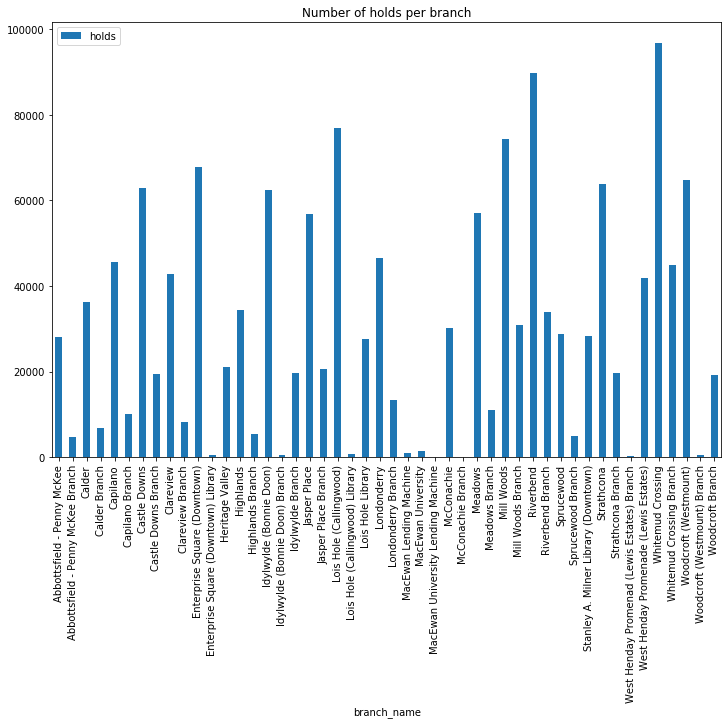

In [9]:
# is there any unit that is getting an abnormal number of holds - and being a potential outlier for our numbers? 


d = data[['title', 'holds', 'branch_name']]

d_group = d.groupby(['branch_name']).agg({'holds':'sum'})
d_group.plot(kind='bar')
plt.title('Number of holds per branch')



> ### Another good think to keep in mind: books preferred in the branches fo : Whitemud, Riverbend and Milwood  will have a real push for the top, due to their capacity and volume of holds

# Data Analysis

### Some questions to solve:

 - What are the most popular books?
 - Are the popular books popular in all branchs?
 - Are there any patterns concerning the genre of books? what about genre in different branches?
 

### - 'What are the most popular books?' 

In [10]:
# most number of holds

a = data[['title', 'genre', 'holds']]
a = a.groupby('title').sum().sort_values('holds', ascending=False).head(15)

a

,holds
title,
The girl on the train,39505
The life-changing magic of tidying up : the Japanese art of decluttering and organizing,22365
Cambridge IELTS ... : examination papers from the University of Cambridge Local Examinations Syndicate,21708
The subtle art of not giving a fuck : a counterintuitive approach to living a good life,15583
Into the water,14219
12 rules for life : an antidote to chaos,12480
All the light we cannot see : a novel,11615
The Alice network,11399
The hate u give,10927


In [11]:
# most number of appearances in the top 10 list
b = data[['title', 'holds']]
b = b.groupby('title').size().sort_values(ascending=False).head(15)

b

title
The girl on the train                                                                                     1255
The life-changing magic of tidying up : the Japanese art of decluttering and organizing                   1048
Cambridge IELTS ... : examination papers from the University of Cambridge Local Examinations Syndicate     604
All the light we cannot see : a novel                                                                      600
The illegal : a novel                                                                                      444
Me before you                                                                                              434
The nest                                                                                                   341
Harry Potter and the cursed child. Parts one and two                                                       296
Why not me?                                                                                               

In [12]:
topHold = a.index.tolist()
topAppear = b.index.tolist()
hold_in_appear = sum([1 for x in topHold if x in topAppear])

print('{} of 15 in the most holded books list appears among the top 15 on weeks being featured in the top 10.'.format(hold_in_appear))

5 of 15 in the most holded books list appears among the top 15 on weeks being featured in the top 10.


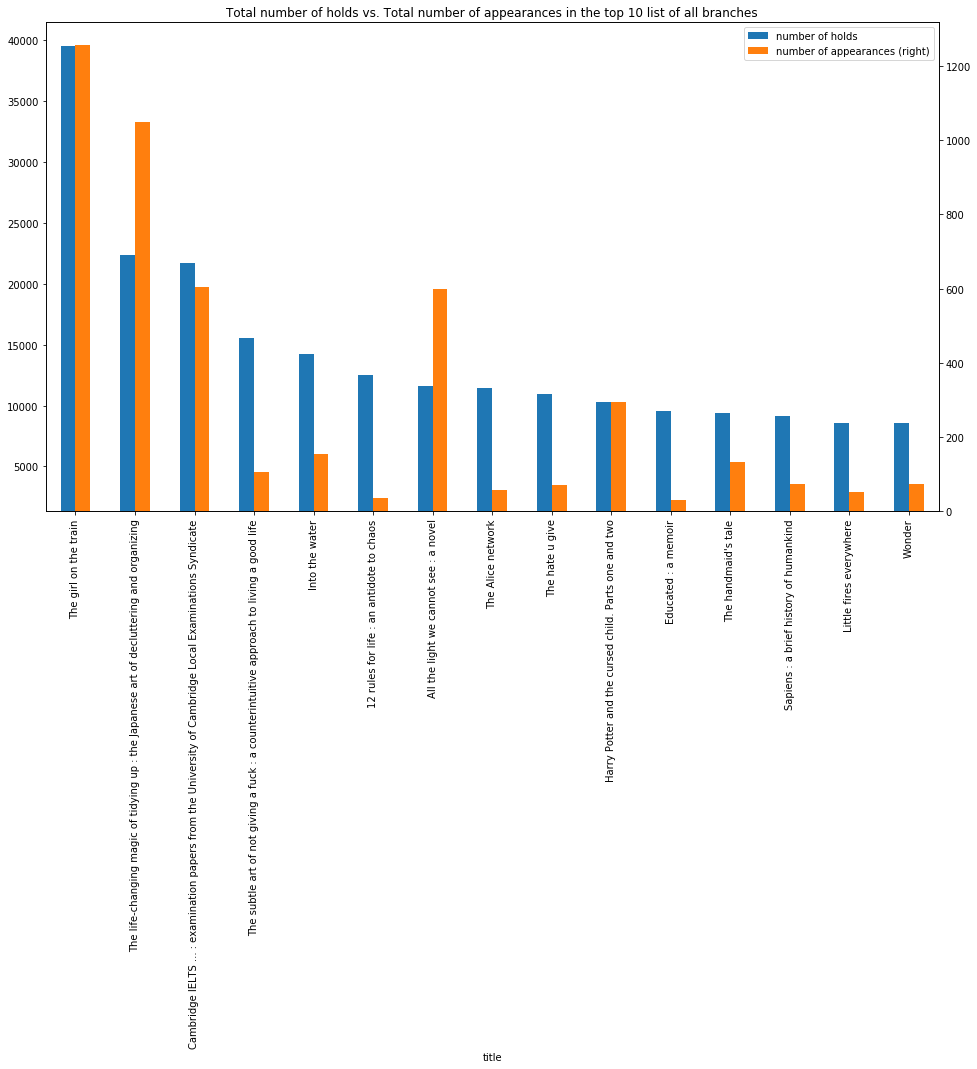

In [13]:
c = data[['title', 'holds']]
c = c.groupby('title').agg({'holds' : 'sum', 'title' : 'size'}).sort_values('holds', ascending=False)
c.columns=['number of holds', 'number of appearances']

#ploting to see the difference betweeen number of holds vs number of weeks in top 10
c.iloc[:15].plot(kind='bar', secondary_y='number of appearances', ylim=1300, figsize=[16,9])
plt.title('Total number of holds vs. Total number of appearances in the top 10 list of all branches')
plt.savefig('hold_appear.png', bbox_inches = "tight")

>Following some logic, we would expect that the most number of holdings would come from the most featured books (concerning the most number of appearances in the top 10's). But, in the graph above we can see some cases that follow this logic (candidates for perennial sucesses), but some interesting ones that don't(candidates for spike trends).

**Candidates for external spike trends**: The subtle art of not[..], Into the water, 12 rules for life, Into the water

**Candidates for perennial sucesses**: The girl on the train, The life-changing magic of tidying up, Cambrideg IELTS



### Let's make a further investigation:

##### Candidates for perennial sucesses:

In [14]:
# Preparing the base of the graphs
holdsOnTime = data[['title', 'holds', 'date']]
holdsOnTime = holdsOnTime.set_index('title')
holdsOnTime.loc[:,'date'] = pd.to_datetime(holdsOnTime['date'])

holdsOnTime.loc[:,'hold_year'] = holdsOnTime.date.dt.year

ht_group = holdsOnTime.groupby(['title', 'hold_year']).sum().sort_values(['title', 'hold_year'])

perennials = ['The girl on the train',
             'The life-changing magic of tidying up : the Japanese art of decluttering and organizing',
              'Cambridge IELTS ... : examination papers from the University of Cambridge Local Examinations Syndicate'
             ]

Text(0.5, 1.0, 'Number of holds per title per year')

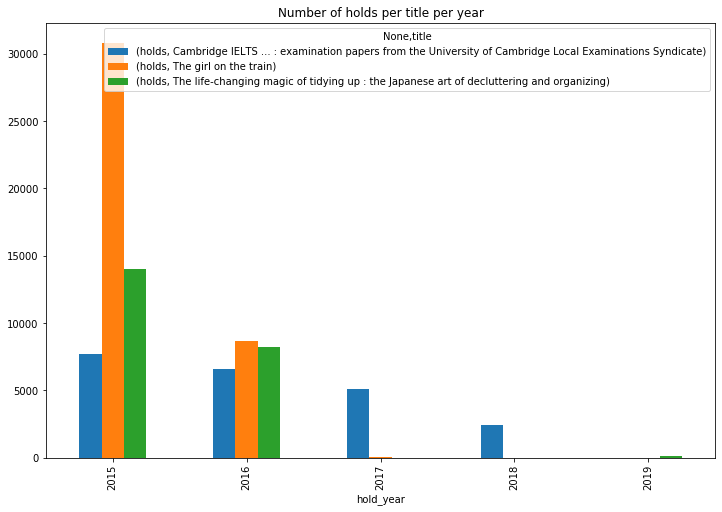

In [15]:
ht_group.loc[perennials].unstack(level=0).plot(kind='bar')
plt.title('Number of holds per title per year')
#plt.savefig('moment_trend2.png', bbox_inches = "tight")

#### Candidates for external spike trends

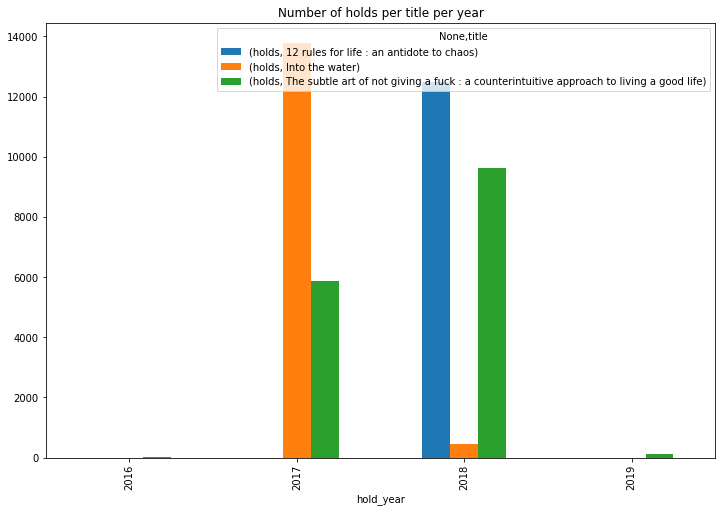

In [16]:
external = ['12 rules for life : an antidote to chaos', 
            'The subtle art of not giving a fuck : a counterintuitive approach to living a good life',
            'Into the water'
           ]

ht_group.loc[external].unstack(level=0).sort_index().plot(kind='bar')
plt.title('Number of holds per title per year')
plt.savefig('moment_trend.png', bbox_inches = "tight")

> So, for the **perennial sucesses** we could say that only IELTS could hold the title, once it kept the demand through all the years. Which was not the case for the other ones which we could say a very ocassional demand that suddenly stops
---
> For the **spike trends** we could see that is in part true, mainly because of 12 rules for life title that had this high demand on the year it was published(2018) and just vanished after that in the next year.


But there is one thng missing here: **what about the impact of individual branches? Is this popularity affected by being featured on few specific branches (with elevated holding numbers?)**

Let's see:

### 'Are the popular books popular in all branches?'

Mean Concentration rate in the top 15: 0.1933937334961127


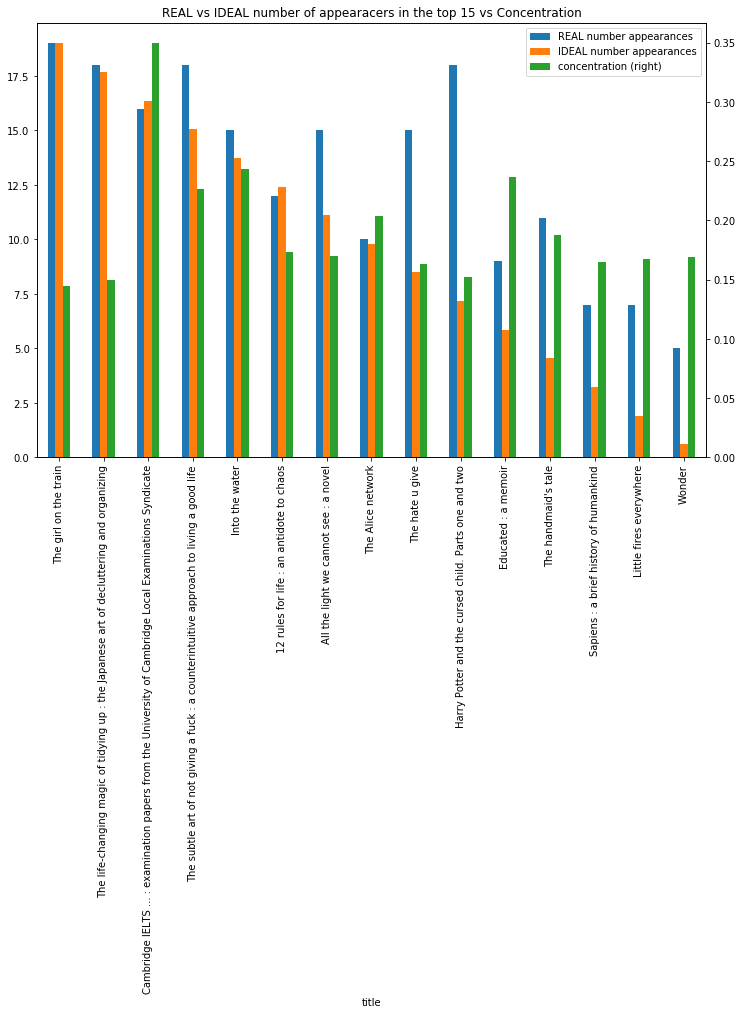

In [17]:
# how are the top 15 in holdings perfoming when considering the branches separatedly?

d = data[['title', 'holds', 'branch_name']]

d_group = d.groupby(['branch_name','title']).agg({'holds':'sum'})
d_group = d_group.sort_values(['branch_name', 'holds'], ascending=False)

# Making the ranks by title and position in the branch tier list
branches = list({branch[0] for branch in d_group.index })

topByTitle = {} # { title : [positions got from individual branches ranks] }
for branch in branches:
    positions = []
    count = 1
    for index, row in d_group.loc[branch].iterrows():
        if count <= 15:
            try:
                topByTitle[index].append(count)
                count += 1
            except KeyError :
                topByTitle[index] = []
                topByTitle[index].append(count)
                count += 1

#{ title : number of appearances in ranks from different branches } 
topByTitle_count = { key:[len(lst)] for key, lst in topByTitle.items() if key in topHold } 
for key, value in topByTitle_count.items():
    topByTitle_count[key].append(a.loc[key,].holds)
topByTitle_count = {k:v for k,v in sorted(topByTitle_count.items(), key=lambda item: item[1][1], reverse=True)}
appearances = [ topByTitle_count[title][0] for title in topHold]

# Creating IDEAL World distribution with constant decay after the 1st place
decay = 1.3142 # manually found

ideal_appearances = []
ideal_appearances.append(max(appearances))

for x in range(len(appearances)-1):
    ideal_appearances.append(ideal_appearances[x]-decay)
    
# Geting concentration index, concentration = what is the % of the branch with more 
# holds on the title comparing the total

e = data[['title', 'holds', 'branch_name']]

e_group = e.groupby(['title','branch_name']).agg({'holds':'sum'})
e_group = e_group.sort_values(['title','holds'],ascending=False)

concentration = []
for title in topByTitle_count.keys():
    calculate = True
    for index, row in e_group.loc[title].iterrows():
        if calculate:
            concentration.append((row['holds']/a.loc[title]['holds']))
            calculate = False

print('Mean Concentration rate in the top 15: {}'.format(sum(concentration)/len(concentration)))

## creating DataFrame to facilitate plot

top_dt_dict ={
    'title': list(topByTitle_count.keys()),
    'REAL number appearances': appearances,
    'IDEAL number appearances': ideal_appearances,
    'concentration' : concentration
}

topTitlesDt = pd.DataFrame(top_dt_dict)
topTitlesDt = topTitlesDt.set_index('title')
topTitlesDt.plot(kind='bar', secondary_y = 'concentration')
plt.title('REAL vs IDEAL number of appearacers in the top 15 vs Concentration')
plt.savefig('concentration.png', bbox_inches = "tight")

In [18]:
Concentration_map = {}
e_group2 = e_group.reset_index('branch_name')
for title in topByTitle_count.keys():
    calculate = True
    Concentration_map[title] = 0
    for index, row in e_group2.loc[title].iterrows():
        if calculate:
            Concentration_map[title] = row['branch_name']
            calculate = False
Concentration_map

{'The girl on the train': 'Whitemud Crossing Branch',
 'The life-changing magic of tidying up : the Japanese art of decluttering and organizing': 'Whitemud Crossing Branch',
 'Cambridge IELTS ... : examination papers from the University of Cambridge Local Examinations Syndicate': 'Mill Woods Branch',
 'The subtle art of not giving a fuck : a counterintuitive approach to living a good life': 'Whitemud Crossing',
 'Into the water': 'Riverbend',
 '12 rules for life : an antidote to chaos': 'Riverbend',
 'All the light we cannot see : a novel': 'Riverbend Branch',
 'The Alice network': 'Riverbend',
 'The hate u give': 'Whitemud Crossing',
 'Harry Potter and the cursed child. Parts one and two': 'Whitemud Crossing Branch',
 'Educated : a memoir': 'Whitemud Crossing',
 "The handmaid's tale": 'Whitemud Crossing',
 'Sapiens : a brief history of humankind': 'Riverbend',
 'Little fires everywhere': 'Riverbend',
 'Wonder': 'Whitemud Crossing'}

**Concentration** = The % which the branch with greater holding numbers for that title, represents in the total number

>  First: in the top 15 of all time, concetration is relative high, 19% - against the natural mean that would be 4.5% (1/22)
---
> Second: the top 2 books showed tht they are a spread phenomenon, showing their appreciation the many different branches. 
---
> Third: Our candidate for perennial sucess is fed by a particular branch (Millwoods Branch) - 40% concentration
---
> Forth: The tail of our top 15 seems to rely more in concentration to be featured in the rank - mostly carried by Whitemud branch


### Exploring Publication Dates

/Users/fernandomeira/.local/share/virtualenvs/EdmontonLibraryEDA-hCCnIGB0/lib/python3.8/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/fernandomeira/.local/share/virtualenvs/EdmontonLibraryEDA-hCCnIGB0/lib/python3.8/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


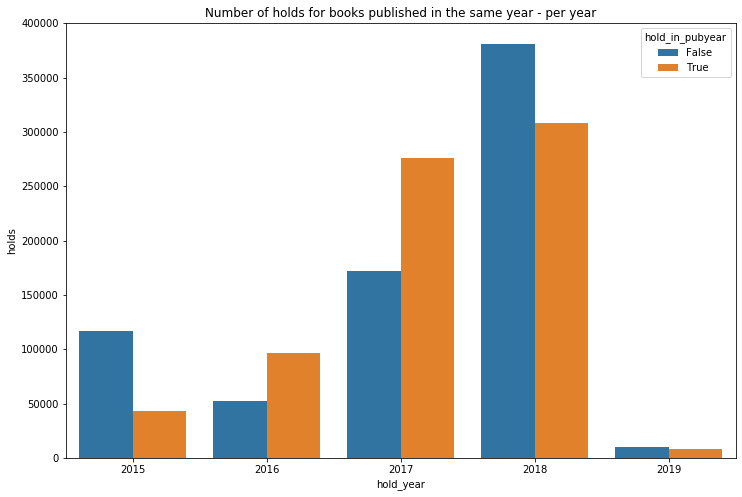

In [77]:
#checking for patterns in books holded in the same yer they were published

pubd = data[['title', 'pubdate', 'date', 'holds']]
pubd.loc[:,'date'] = pd.to_datetime(pubd['date'])
pubd.loc[:,'pubdate'] = pd.to_datetime(pubd['pubdate'])
pubd.loc[:,'hold_year'] = pubd.date.dt.year
pubd.loc[:,'pub_year'] = pubd.pubdate.dt.year

pubd.loc[:,'hold_in_pubyear'] = pubd.hold_year == pubd.pub_year

pubd_group_general = pubd.groupby(['hold_year', 'hold_in_pubyear']).agg({'holds':'sum'})
pubd_group_general = pubd_group_general.reset_index()

sns.barplot(x='hold_year', y='holds', hue='hold_in_pubyear', data=pubd_group_general)
plt.title('Number of holds for books published in the same year - per year')
plt.savefig('pubyear.png', bbox_inches = "tight")

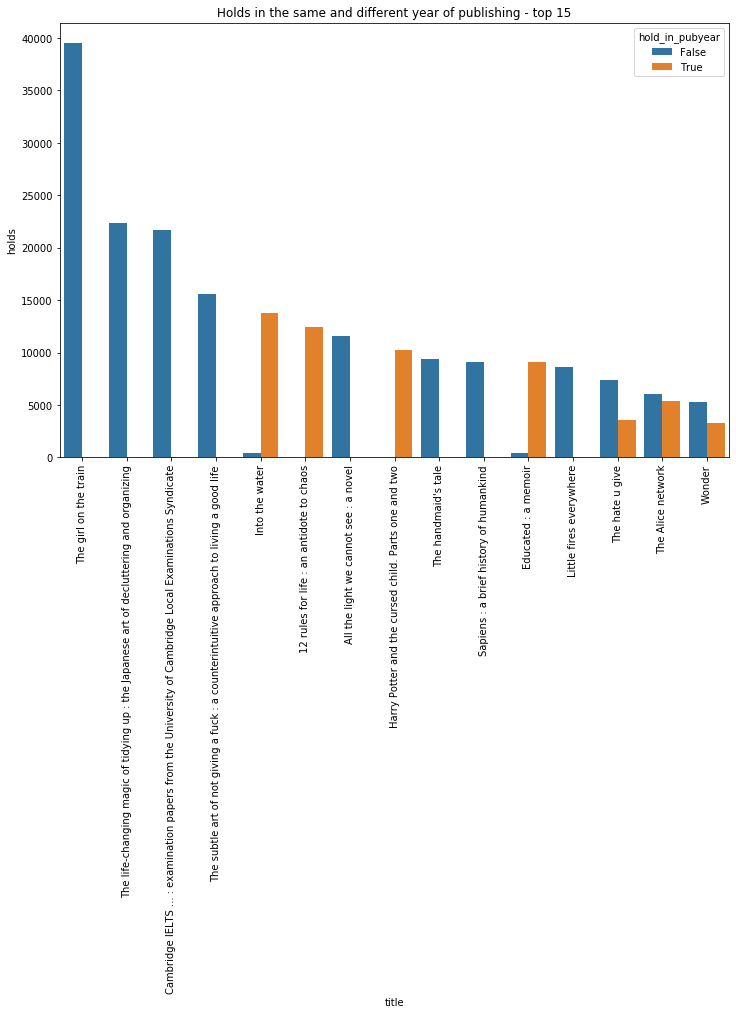

In [78]:
# lets check the same pattern but for the top 15 books
top15_titles = list(topByTitle_count.keys())

pubd_group_top15 = pubd.groupby(['title', 'hold_in_pubyear']).agg({'holds':'sum'}).reset_index()
pubd_group_top15 = pubd_group_top15.set_index('title')
pubd_group_top15 = pubd_group_top15.loc[top15_titles,:].sort_values('holds', ascending=False).reset_index()

sns.barplot(x='title', y='holds', hue='hold_in_pubyear', data=pubd_group_top15)
plt.xticks(rotation=90)
plt.title('Holds in the same and different year of publishing - top 15')
plt.savefig('pubyear_title.png', bbox_inches = "tight")

As we can see above, the 

### Exploring Genres

In [19]:
genr = data[['genre', 'holds']]

genr.groupby('genre').sum().sort_values('holds', ascending=False).iloc[:15]#.plot(kind='bar', logy=True)

,holds
genre,
Fiction,735076
Biography & Autobiography,108627
Juvenile Fiction,91640
Self-Help,73953
Cooking,53520
Drama,53038
Young Adult Fiction,47791
Health & Fitness,35748
House & Home,27192


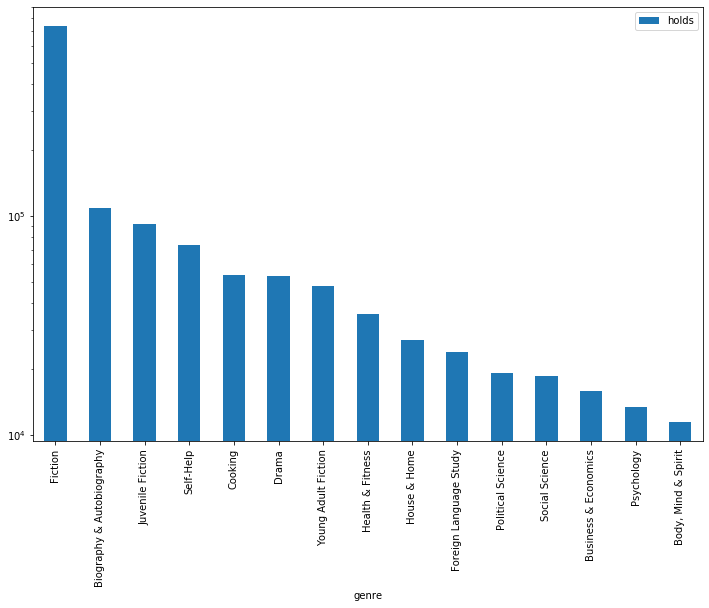

In [20]:
genr.groupby('genre').sum().sort_values('holds', ascending=False).iloc[:15].plot(kind='bar', logy=True)

> So, all time favorite is Fiction, by far (double), followed by biographies and juvenile fiction

Text(0.5, 1.0, 'Genres All time hold number evolution')

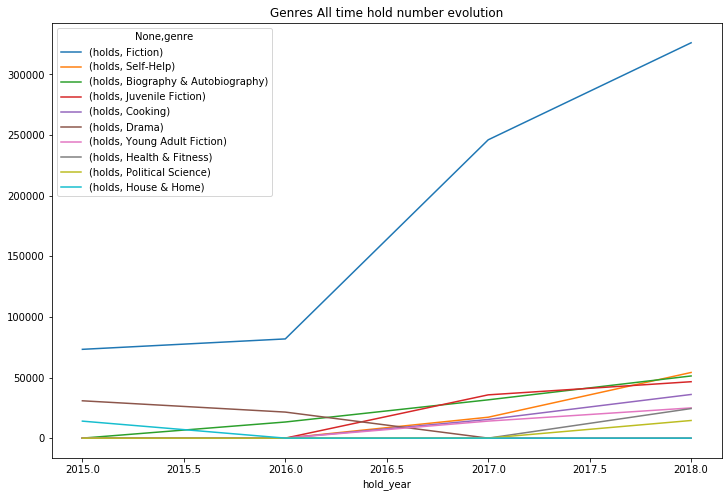

In [21]:
# seeing genre evolution overtime
genrt = data[['genre', 'date', 'holds']]
genrt = genrt.set_index('genre')
genrt.loc[:,'date'] = pd.to_datetime(genrt['date'])
genrt.loc[:,'hold_year'] = genrt.date.dt.year

genrt_group = genrt.groupby(['genre','hold_year']).sum().sort_values(['holds','hold_year'], ascending=False)
genrt_group.iloc[:20,].unstack(level=0).fillna(0).plot()
plt.title('Genres All time hold number evolution')

Text(0.5, 1.0, 'Genres All time hold number evolution - EXCLUDING FICTION')

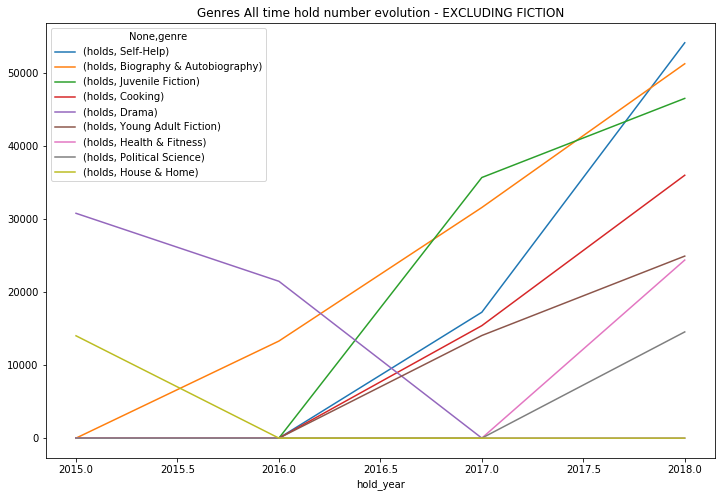

In [22]:
genrt_group.iloc[:20,].unstack(level=0).iloc[:,1:].fillna(0).plot()
plt.title('Genres All time hold number evolution - EXCLUDING FICTION')

> Again, fiction domination and showing a lot o growth, followed by juvenile fiction and biographies, with a goo shout out to self-help and cooking - showing some interesting growth)

##### But how is evolution in genres which year? is there any change?

<Figure size 864x432 with 0 Axes>

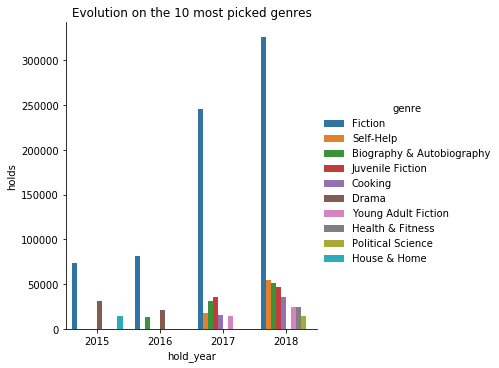

In [23]:
genrt_group2 = genrt_group.reset_index().iloc[:20,]

plt.figure(figsize=(12, 6))
sns.catplot(x='hold_year', y='holds', hue='genre', data=genrt_group2, kind='bar')
plt.title('Evolution on the 10 most picked genres')
plt.savefig('genre_evolution.png', bbox_inches = "tight")

> Here the most notable and interesting fact is: **from 2015, we are seeing a good progress in the variety of the books featured in the top 10's!**

What made this more than exponencial growth (starting in 2017) in fiction category?

Text(0.5, 1, 'Evolution on the 10 most picked fiction books')

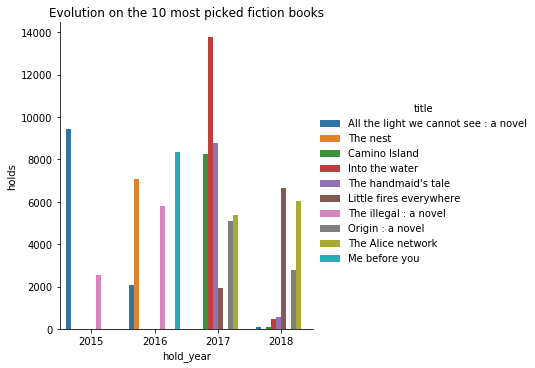

In [24]:
# checking for concentration in the all time top 10 most holded books

fictionDt = data[['genre', 'date', 'holds', 'title']]
fictionDt = fictionDt[fictionDt.genre == 'Fiction']
fictionDt.loc[:,'date'] = pd.to_datetime(fictionDt['date'])
fictionDt.loc[:,'hold_year'] = fictionDt.date.dt.year

#getting 10 most holded titles
fiction10 = data[data.genre == 'Fiction']
fiction10 = fiction10[['holds', 'title']]
fiction10 = fiction10.groupby('title').sum().sort_values('holds', ascending=False).reset_index()
top10 = fiction10.iloc[:10,0].tolist()

fiction_g = fictionDt.groupby(['title', 'hold_year']).sum().sort_values('holds')
fiction_ev = fiction_g.loc[top10,].reset_index()

sns.catplot(x='hold_year', y='holds', hue='title', data=fiction_ev, kind='bar')
plt.title('Evolution on the 10 most picked fiction books')

Well, from a first look it seems that titles like 'Into the water' and company are responsible for all that growth right? No. Not too fast.

Let's check the participation of the top 10 fiction books in holding and see their participation during the years:

Text(0.5, 1.0, 'Participation in % of the 10 all time fiction books on holdings')

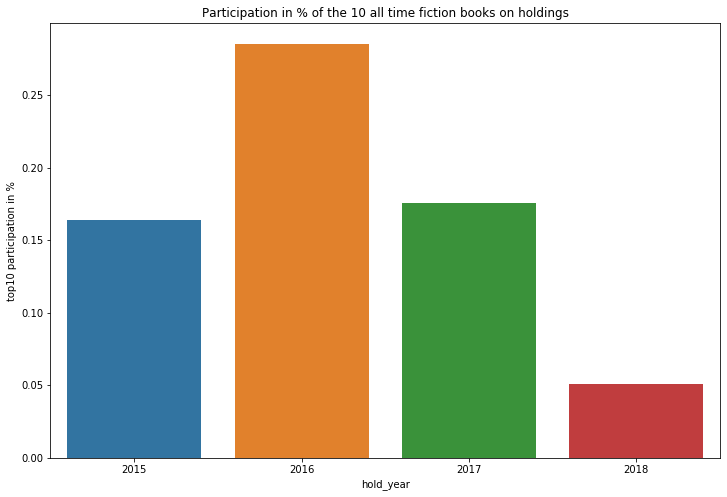

In [25]:
# checking the participation of this top 10 books on the overall value of holds for fiction by year

# geting the sum of holds of the top 10 by year
top10_totals = fiction_ev.groupby('hold_year').sum().reset_index()#holds.tolist()
top10_dict = {row['hold_year']:row['holds'] for index,row in top10_totals.iterrows()}

#geting the total number of holds of fiction by year and final dataframe
comparisonDt = genrt_group2[genrt_group2.genre=='Fiction'].groupby('hold_year').sum().reset_index()
comparisonDt['top10 holds'] = comparisonDt['hold_year'].apply(lambda x: top10_dict[x])
comparisonDt['top10 participation in %'] = comparisonDt['top10 holds']/comparisonDt['holds']

sns.barplot(x='hold_year', y='top10 participation in %', data=comparisonDt)
plt.title('Participation in % of the 10 all time fiction books on holdings')


> Well, it seems that we have an interesting picture above. Even though we are seeing great growth in fiction, this comes, year after year, as a spread movement. In summary: the interest in fiction is growing and it is get more and more diversified each year.
---


Ok, what if we took off fiction form the picture?

Text(0.5, 1, 'Evolution on the 10 most picked genres - WITHOUT FICTION')

<Figure size 864x432 with 0 Axes>

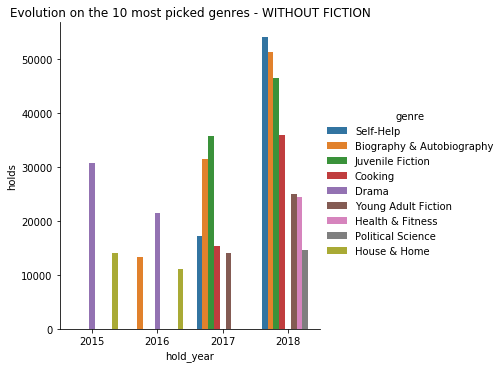

In [26]:
genrt_group2 = genrt_group.reset_index().iloc[:21,:]
genrt_group2 = genrt_group2[genrt_group2.genre != 'Fiction']


plt.figure(figsize=(12, 6))
sns.catplot(x='hold_year', y='holds', hue='genre', data=genrt_group2, kind='bar')
plt.title('Evolution on the 10 most picked genres - WITHOUT FICTION')

> Still : diversification is the word here.

##### Exploring genre patterns geographically

In [27]:
#getting the addresses of the branches 
brcInfo = pd.read_csv('Public_Libraries.csv')
keep_columns = ['Branch ID', 'Branch', 'Address', 'Latitude', 'Longitude']
brcInfo = brcInfo[keep_columns]

brcInfo.sort_values('Branch ID').head()

,Branch ID,Branch,Address,Latitude,Longitude
7,EPLABB,Abbottsfield - Penny McKee,3410 - 118 Avenue,53.570451,-113.391518
20,EPLCAL,Calder,12710 - 131 Avenue NW,53.590515,-113.542369
12,EPLCLV,Clareview,3808 - 139 Avenue,53.601302,-113.401769
14,EPLCPL,Capilano,9915 - 67 Street,53.537896,-113.419927
11,EPLCSD,Castle Downs,"106 Lakeside Landing, 15379 Castle Downs Rd",53.615736,-113.516633


In [28]:
#Creating the data frame by branch and genre to start exploring
g = data[['branch_id', 'date', 'genre', 'holds']]
g.loc[:,'date'] = pd.to_datetime(g['date'])
g.loc[:,'hold_year'] = g.date.dt.year

# merging
g_group = g.groupby(['hold_year', 'branch_id', 'genre']).sum().sort_values(['hold_year', 'branch_id', 'holds'], ascending=False)
g_group = g_group.reset_index()
g_merged = g_group.merge(brcInfo, right_on='Branch ID', left_on='branch_id').set_index('hold_year')
g_merged.head()

/Users/fernandomeira/.local/share/virtualenvs/EdmontonLibraryEDA-hCCnIGB0/lib/python3.8/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/fernandomeira/.local/share/virtualenvs/EdmontonLibraryEDA-hCCnIGB0/lib/python3.8/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


,branch_id,genre,holds,Branch ID,Branch,Address,Latitude,Longitude
hold_year,,,,,,,,
2019,EPLWOO,Fiction,590,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
2019,EPLWOO,Biography & Autobiography,294,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
2019,EPLWOO,Young Adult Fiction,244,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
2019,EPLWOO,Cooking,77,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
2018,EPLWOO,Fiction,19270,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864


In [29]:
#geting the most popular genre per branch, per year considering number of holds

# building the dict for the job!
branch_ids = g_merged.branch_id.unique().tolist()
years = [2015, 2016, 2017, 2018]

master_dict = {}

for year in years:
    master_content = {}
    base = g_merged.loc[year, ['genre','holds', 'branch_id', 'Latitude', 'Longitude', 'Branch']]
    for branch in branch_ids:
        inside_content = {}
        try:
            inside_content['Branch'] = base[base.branch_id == branch].iloc[0,]['Branch']
            inside_content['genre'] = base[base.branch_id == branch].iloc[0,]['genre']
            inside_content['holds'] = base[base.branch_id == branch].iloc[0,]['holds']
            inside_content['Latitude'] = base[base.branch_id == branch].iloc[0,]['Latitude']
            inside_content['Longitude'] = base[base.branch_id == branch].iloc[0,]['Longitude']
            master_content[branch] = inside_content
        except:
            continue
        
    master_dict[year] = master_content

In [30]:
# normalization function - for the marker size 

def normalize(number, upper=20, lower=1):
    normalized = ((number -lower)/(upper - lower)) * 10 
    return int(normalized+9) # +6 to make small numbers more visible in the map

# colors for markers
marker_c = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
            'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 
            'darkpurple', 'pink', 'lightblue', 'lightgreen', 
            'gray', 'black', 'lightgray']


In [31]:
#base map
m = folium.Map(location=[53.531611, -113.513975], zoom_start=11.4)

#Generating the color of the markers
np.random.seed(5)
top_genre = set()
for key, value in master_dict.items():
    for key2, value2 in value.items():
        top_genre.add(value2['genre'])
    
genre_color = {genre:marker_c[np.random.randint(0,len(marker_c)-1)] for genre in top_genre}

@interact(year = widgets.IntSlider(min=2015, max=2018, step=1, value=2015))
def generate_geo_genre(year=[2015, 2016, 2017, 2018]):
    '''Generate Geo Map with round markers with the size of number of holds per genre in each branch
       Represents all time sucesses in number of holds
       
       year = integer, year you would like to analyze
        '''
    
    m = folium.Map(location=[53.531611, -113.513975], zoom_start=11.4)
    
    #Generating the color of the markers
    np.random.seed(1)
    top_genres = {values['genre'] for key,values in master_dict[year].items()}
    genre_color_checking = {genre:genre_color[genre] for genre in top_genres}
    
    #seting up parameters for the marker size
    hold_list = [value['holds'] for key,value in master_dict[year].items() ]
    maxH, minH = max(hold_list), min(hold_list)

    for branch, values in master_dict[year].items():
        folium.CircleMarker([values['Latitude'], values['Longitude']],
                                radius = normalize(values['holds'], maxH, minH),
                                popup = [values['genre']],
                                color = 'gray',
                                fill=True,
                                fill_opacity=0.9,
                                fill_color=genre_color[values['genre']],
                                tooltip= values['Branch'],
                               ).add_to(m)
        
    #generate legends snipets
    snipets = []
    for key, value in genre_color_checking.items():
        snipets.append(
            '&nbsp; {} &nbsp; <i class="fa fa-map-marker fa-2x" style="color:{}"></i>'.format(
                                                                                        key, value)
        )
    legend_entries = '<br>'.join(snipets)
        
        
    year_html = '''
        <div style="position: fixed; 
                            top: 10px; right: 10px; width: auto; height: auto; 
                            z-index:9999; font-size:14px;
                            color: black; font-size: 45px;
                            ">&nbsp; <b> {}  </b> <br>
                              </i>
                </div>'''.format(year) 
    
    legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: auto; height: auto; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            background-color:white; border-radius:10px; padding: 7px 9px 7px;
                            ">&nbsp; <b> Map Legend  </b> <br>
                            {}
                              </i>
                </div>
                '''.format(legend_entries) 

    m.get_root().html.add_child(folium.Element(legend_html))
    m.get_root().html.add_child(folium.Element(year_html))
    print('Predominant Genre in number of all time holdings by branch')
    
    return m

interactive(children=(IntSlider(value=2015, description='year', max=2018, min=2015), Output()), _dom_classes=(…

> Millwoods resisted the Fiction domination, but it was just a matter of time.. 

Lets try **taking off Fiction** to see other predominant Genres 

In [32]:
#geting the most popular genre per branch, per year considering number of holds

# building the dict for the job!
branch_ids = g_merged.branch_id.unique().tolist()
years = [2015, 2016, 2017, 2018]

g_merged_wf = g_merged[g_merged.genre != 'Fiction'] # Taking off Fiction

master_dict2 = {}

for year in years:
    master_content = {}
    base = g_merged_wf.loc[year, ['genre','holds', 'branch_id', 'Latitude', 'Longitude', 'Branch']]
    for branch in branch_ids:
        inside_content = {}
        try:
            inside_content['Branch'] = base[base.branch_id == branch].iloc[0,]['Branch']
            inside_content['genre'] = base[base.branch_id == branch].iloc[0,]['genre']
            inside_content['holds'] = base[base.branch_id == branch].iloc[0,]['holds']
            inside_content['Latitude'] = base[base.branch_id == branch].iloc[0,]['Latitude']
            inside_content['Longitude'] = base[base.branch_id == branch].iloc[0,]['Longitude']
            master_content[branch] = inside_content
        except:
            continue
        
    master_dict2[year] = master_content

In [33]:
#base map
m2 = folium.Map(location=[53.531611, -113.513975], zoom_start=11.4)

#Generating the color of the markers
np.random.seed(15)
top_genre2 = set()
for key, value in master_dict2.items():
    for key2, value2 in value.items():
        top_genre2.add(value2['genre'])
    
genre_color2 = {genre:marker_c[np.random.randint(0,len(marker_c)-1)] for genre in top_genre2}

# Running it without fiction
@interact(year = widgets.IntSlider(min=2015, max=2018, step=1, value=2015))
def generate_geo_genre(year=[2015, 2016, 2017, 2018]):
    '''Generate Geo Map with round markers with the size of number of holds per genre in each branch
       Represents all time sucesses in number of holds
       
       year = integer, year you would like to analyze
        '''
    
    m2 = folium.Map(location=[53.531611, -113.513975], zoom_start=11.4)
    
    #checking which markers should appear
    top_genres = {values['genre'] for key,values in master_dict2[year].items()}
    genre_color_check = {genre:genre_color2[genre] for genre in top_genres}
    
    
    #seting up parameters for the marker size
    hold_list = [value['holds'] for key,value in master_dict[year].items() ]
    maxH, minH = max(hold_list), min(hold_list)

    for branch, values in master_dict2[year].items():
        folium.CircleMarker([values['Latitude'], values['Longitude']],
                                radius = normalize(values['holds'], maxH, minH),
                                popup = [values['genre']],
                                color = 'grey',
                                fill=True,
                                fill_opacity=0.9,
                                fill_color=genre_color2[values['genre']],
                                tooltip= values['Branch'],
                               ).add_to(m2)
        
    #generate legends snipets
    snipets = []
    for key, value in genre_color_check.items():
        snipets.append(
            '&nbsp; {} &nbsp; <i class="fa fa-map-marker fa-2x" style="color:{}"></i>'.format(
                                                                                        key, value)
        )
    legend_entries = '<br>'.join(snipets)
        
        
    year_html = '''
        <div style="position: fixed; 
                            top: 10px; right: 10px; width: auto; height: auto; 
                            z-index:9999; font-size:14px;
                            color: black; font-size: 45px;
                            ">&nbsp; <b> {}  </b> <br>
                              </i>
                </div>'''.format(year) 
    
    legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: auto; height: auto; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            background-color:white; border-radius:10px; padding: 7px 9px 7px;
                            ">&nbsp; <b>Map Legend</b> <br>
                            {}
                              </i>
                </div>
                '''.format(legend_entries) 

    m2.get_root().html.add_child(folium.Element(legend_html))
    m2.get_root().html.add_child(folium.Element(year_html))
    print('Predominant Genre in number of all time holdings by branch - WITHOUT FICTION')
    
    return m2

interactive(children=(IntSlider(value=2015, description='year', max=2018, min=2015), Output()), _dom_classes=(…

### Exploring HeatMaps

##### Variety HeatMap - Areas with more diversity of genres in the top 10s

In [34]:
#Creating the data frame by branch and genre to start exploring
h = data[['branch_id', 'date', 'genre']]
h.loc[:,'date'] = pd.to_datetime(h['date'])
h.loc[:,'hold_year'] = h.date.dt.year

h_group = h.groupby(['hold_year', 'branch_id', 'genre']).agg(genre_count=('genre', 'size'))
h_group = h_group.sort_values(['hold_year', 'branch_id', 'genre_count'], ascending=False).reset_index()

#merging to get coordinates
h_merged = h_group.merge(brcInfo, right_on='Branch ID', left_on='branch_id')#.set_index('hold_year')
h_merged.head()

/Users/fernandomeira/.local/share/virtualenvs/EdmontonLibraryEDA-hCCnIGB0/lib/python3.8/site-packages/pandas/core/indexing.py:1046: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/fernandomeira/.local/share/virtualenvs/EdmontonLibraryEDA-hCCnIGB0/lib/python3.8/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/fernandomeira/.local/share/virtualenvs/EdmontonLibraryEDA-h

,hold_year,branch_id,genre,genre_count,Branch ID,Branch,Address,Latitude,Longitude
0,2019,EPLWOO,Fiction,5,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
1,2019,EPLWOO,Biography & Autobiography,2,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
2,2019,EPLWOO,Young Adult Fiction,2,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
3,2019,EPLWOO,Cooking,1,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
4,2018,EPLWOO,Fiction,198,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864


In [35]:
# Variety of rankings heatmap

# building the dataframe
i = h_merged
i_group = i.groupby(['hold_year', 'branch_id', 'Latitude', 'Longitude']).agg(number_of_genres=('genre','size'))
i_group = i_group.reset_index()

@interact(year = widgets.IntSlider(min=2015, max=2018, step=1, value=2015))
def diversity_heatmap(year=[2015, 2016, 2017, 2018]):

    m3 = folium.Map(location=[53.531611, -113.513975], zoom_start=9.4)
    
    heat_dt = i_group[i_group.hold_year == year]
    heat_dt['weight'] = heat_dt['number_of_genres'] / heat_dt['number_of_genres'].sum()
    
    year_html = '''
        <div style="position: fixed; 
                            top: 10px; right: 10px; width: auto; height: auto; 
                            z-index:9999; font-size:14px;
                            color: black; font-size: 45px;
                            ">&nbsp; <b> {}  </b> <br>
                              </i>
                </div>'''.format(year) 
    
    params = heat_dt[['Latitude', 'Longitude', 'weight']].values
    m3.get_root().html.add_child(folium.Element(year_html))
    m3.add_children(plugins.HeatMap(params, radius=15))
    
    print( 'Regions with more variety of genres in the top 10s')
    return m3

interactive(children=(IntSlider(value=2015, description='year', max=2018, min=2015), Output()), _dom_classes=(…

##### Genre Intensity by area during years - number of apperances in the top 10

In [36]:
# Variety of rankings heatmap

# building the dataframe
j = h_merged
j_group = j.groupby(['hold_year', 'genre', 'Latitude', 'Longitude']).agg(genre_occur=('genre_count','sum'))
j_group = j_group.reset_index()
u_genres = j_group[j_group.genre_occur >=10].genre.sort_values().unique().tolist() #exclude irrelevant

@interact(genre = u_genres, year = widgets.IntSlider(min=2015, max=2018, step=1, value=2015))
def genre_heatmap(year, genre):

    m4 = folium.Map(location=[53.531611, -113.513975], zoom_start=9.4)
    
    heat_dt = j_group[j_group.hold_year == year]
    heat_dt = heat_dt[heat_dt.genre == genre]
    heat_dt['weight'] = heat_dt['genre_occur'] / heat_dt['genre_occur'].sum()
    
    year_html = '''
        <div style="position: fixed; 
                            top: 10px; right: 10px; width: auto; height: auto; 
                            z-index:9999; font-size:14px;
                            color: black; font-size: 45px;
                            ">&nbsp; <b> {}  </b> <br>
                              </i>
                </div>'''.format(year) 
    
    m4.get_root().html.add_child(folium.Element(year_html))
    
    params = heat_dt[['Latitude', 'Longitude', 'weight']].values
    m4.add_child(plugins.HeatMap(params, radius=15))
    
    return m4

interactive(children=(IntSlider(value=2015, description='year', max=2018, min=2015), Dropdown(description='gen…